# Statistical Learning and Data Mining Project 2020

# Trading strategy

Challenges:<br>
1) get data that includes ask price;<br>
2) create ask related features;<br>
3) increase the number of data used (takes too long?);<br>
4) increase the number of epochs;<br>
5) backtest the strategy

In [1]:
#EURUSD_15m_BID_01.01.2010-31.12.2016

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab
from sklearn.ensemble import RandomForestRegressor
#Used TA-Lib for creating additional features. More on this later.
from talib.abstract import *
from talib import MA_Type

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import keras.backend as K

Using TensorFlow backend.


Load the data and get the predictions

In [3]:
data = pd.read_csv("/Users/nastyademina/Desktop/SL project/EURUSD_15m.csv")

In [4]:
print(data.head(10))

           Time     Open     High      Low    Close       Volume
0  1/1/10 00:00  1.43283  1.43293  1.43224  1.43293  608600007.1
1  1/1/10 00:15  1.43285  1.43295  1.43229  1.43275  535600003.2
2  1/1/10 00:30  1.43280  1.43303  1.43239  1.43281  436299999.2
3  1/1/10 00:45  1.43285  1.43294  1.43229  1.43276  614299997.3
4  1/1/10 01:00  1.43287  1.43292  1.43206  1.43282  705300008.8
5  1/1/10 01:15  1.43290  1.43299  1.43212  1.43292  427300005.9
6  1/1/10 01:30  1.43267  1.43305  1.43209  1.43282  399200000.8
7  1/1/10 01:45  1.43280  1.43302  1.43218  1.43249  481200008.4
8  1/1/10 02:00  1.43279  1.43303  1.43237  1.43301  607599996.6
9  1/1/10 02:15  1.43301  1.43303  1.43222  1.43271  469600000.4


In [5]:
data.rename(columns={'Time' : 'Date'}, inplace=True)
data["Date"]=pd.to_datetime(data["Date"], infer_datetime_format=True)
data.set_index('Date', inplace=True)
#data=data.astype(float)
#data=data[data.index>="2015-01-01 00:00:00"]
data.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-01 00:00:00,1.43283,1.43293,1.43224,1.43293,608600007.1
2010-01-01 00:15:00,1.43285,1.43295,1.43229,1.43275,535600003.2
2010-01-01 00:30:00,1.43280,1.43303,1.43239,1.43281,436299999.2
2010-01-01 00:45:00,1.43285,1.43294,1.43229,1.43276,614299997.3
2010-01-01 01:00:00,1.43287,1.43292,1.43206,1.43282,705300008.8


In [6]:
data=data.astype(float)
data=data[data.index>="2015-01-01 00:00:00"]

In [7]:
print(data.head(10))

                        Open     High      Low    Close  Volume
Date                                                           
2015-01-01 00:00:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 00:15:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 00:30:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 00:45:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 01:00:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 01:15:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 01:30:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 01:45:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 02:00:00  1.20976  1.20976  1.20976  1.20976     0.0
2015-01-01 02:15:00  1.20976  1.20976  1.20976  1.20976     0.0


Add additional features

In [8]:
data['Hour'] = data.index.hour
data['Day']  = data.index.weekday
data['Week'] = data.index.week
data['Momentum']  = data['Volume'] * (data['Open'] - data['Close'])
data['Avg_price'] = (data['Low'] + data['High'])/2
data['Range']     = data['High'] - data['Low']
data['Ohlc_price'] = (data['Low'] + data['High'] + data['Open'] + data['Close'])/4
data['Oc_diff']    = data['Open'] - data['Close']

inputs = {
    'open'   : data['Open'].values,
    'high'   : data['High'].values,
    'low'    : data['Low'].values,
    'close'  : data['Close'].values,
    'volume' : data['Volume'].values
}
data['Ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
data['Bear_power'] = data['Low'] - data['Ema']
data['Bull_power'] = data['High'] - data['Ema']
data.dropna(inplace=True)

In [9]:
data.head(5)

,Open,High,Low,Close,Volume,Hour,Day,Week,Momentum,Avg_price,Range,Ohlc_price,Oc_diff,Ema,Bear_power,Bull_power
Date,,,,,,,,,,,,,,,,
2015-01-01 21:00:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 21:15:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 21:30:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 21:45:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 22:00:00,1.21038,1.21064,1.21025,1.21035,244299997.3,22,3,1,7328.999919,1.210445,0.00039,1.210405,0.00003,1.209765,4.851685e-04,8.751685e-04


Add PCA as a feature instead of for reducing the dimensionality. Add 1D PCA vector as a feature as well. This helped increasing the accuracy by adding more variance to the feature set.

In [10]:
dataframe = data.copy().values.astype('float32')
pca_features = data.columns.tolist()
pca = PCA(.99)
pca.fit_transform(data)
pca.n_components_ #how many components PCA choose after fitting the model
pca = PCA(n_components=1)
data['pca'] = pca.fit_transform(dataframe) #Fit the model with X and apply the dimensionality reduction on X
print(pca.explained_variance_ratio_)

[0.99999488]


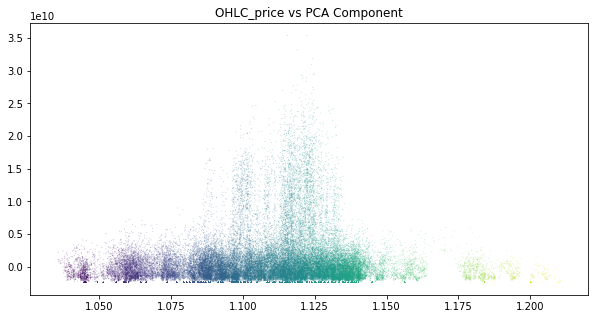

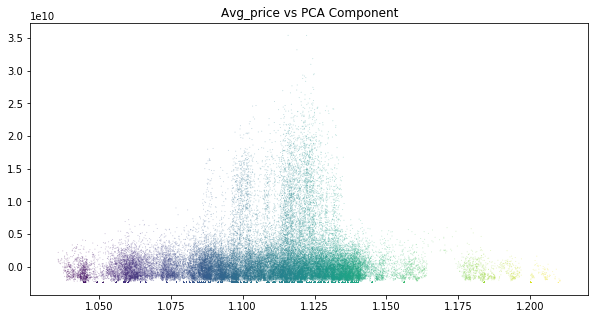

In [11]:
plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Ohlc_price'].values.min(), data['Ohlc_price'].values.max())
color = cm.viridis(norm(data['Ohlc_price'].values))
plt.scatter(data['Ohlc_price'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('OHLC_price vs PCA Component')
plt.show()


plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Avg_price'].values.min(), data['Avg_price'].values.max())
color = cm.viridis(norm(data['Avg_price'].values))
plt.scatter(data['Avg_price'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Avg_price vs PCA Component')
plt.show()


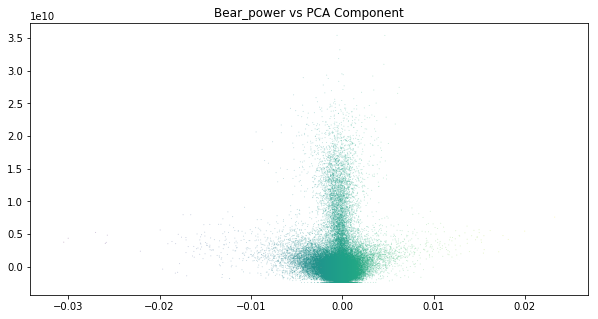

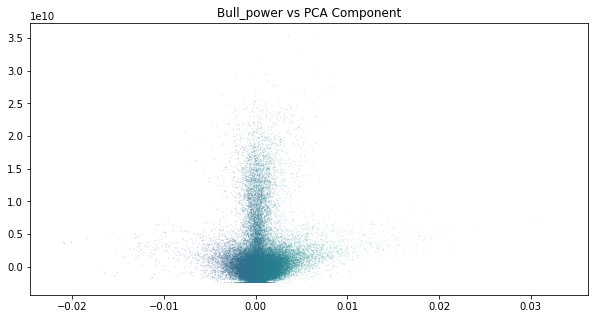

In [12]:
plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Bear_power'].values.min(), data['Bear_power'].values.max())
color = cm.viridis(norm(data['Bear_power'].values))
plt.scatter(data['Bear_power'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Bear_power vs PCA Component')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Bull_power'].values.min(), data['Bull_power'].values.max())
color = cm.viridis(norm(data['Bull_power'].values))
plt.scatter(data['Bull_power'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Bull_power vs PCA Component')
plt.show()

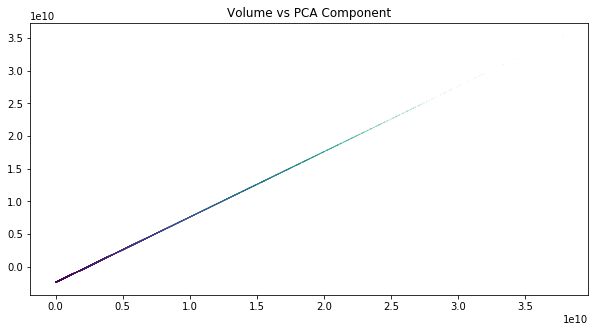

In [13]:
plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Volume'].values.min(), data['Volume'].values.max())
color = cm.viridis(norm(data['Volume'].values))
plt.scatter(data['Volume'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Volume vs PCA Component')
plt.show()

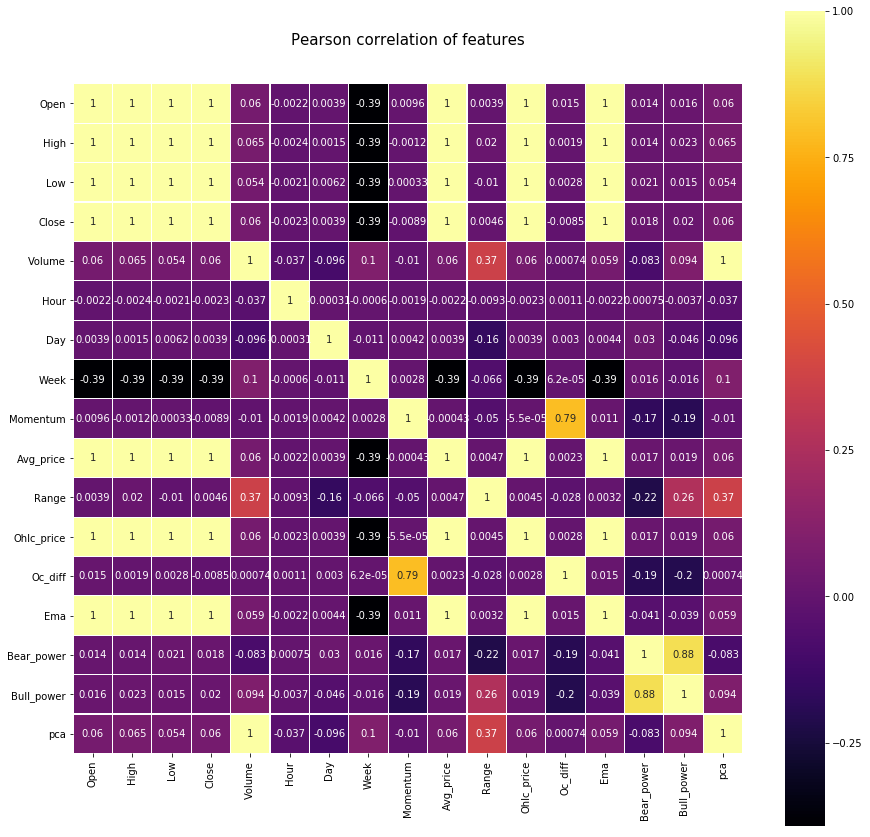

In [14]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(data.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

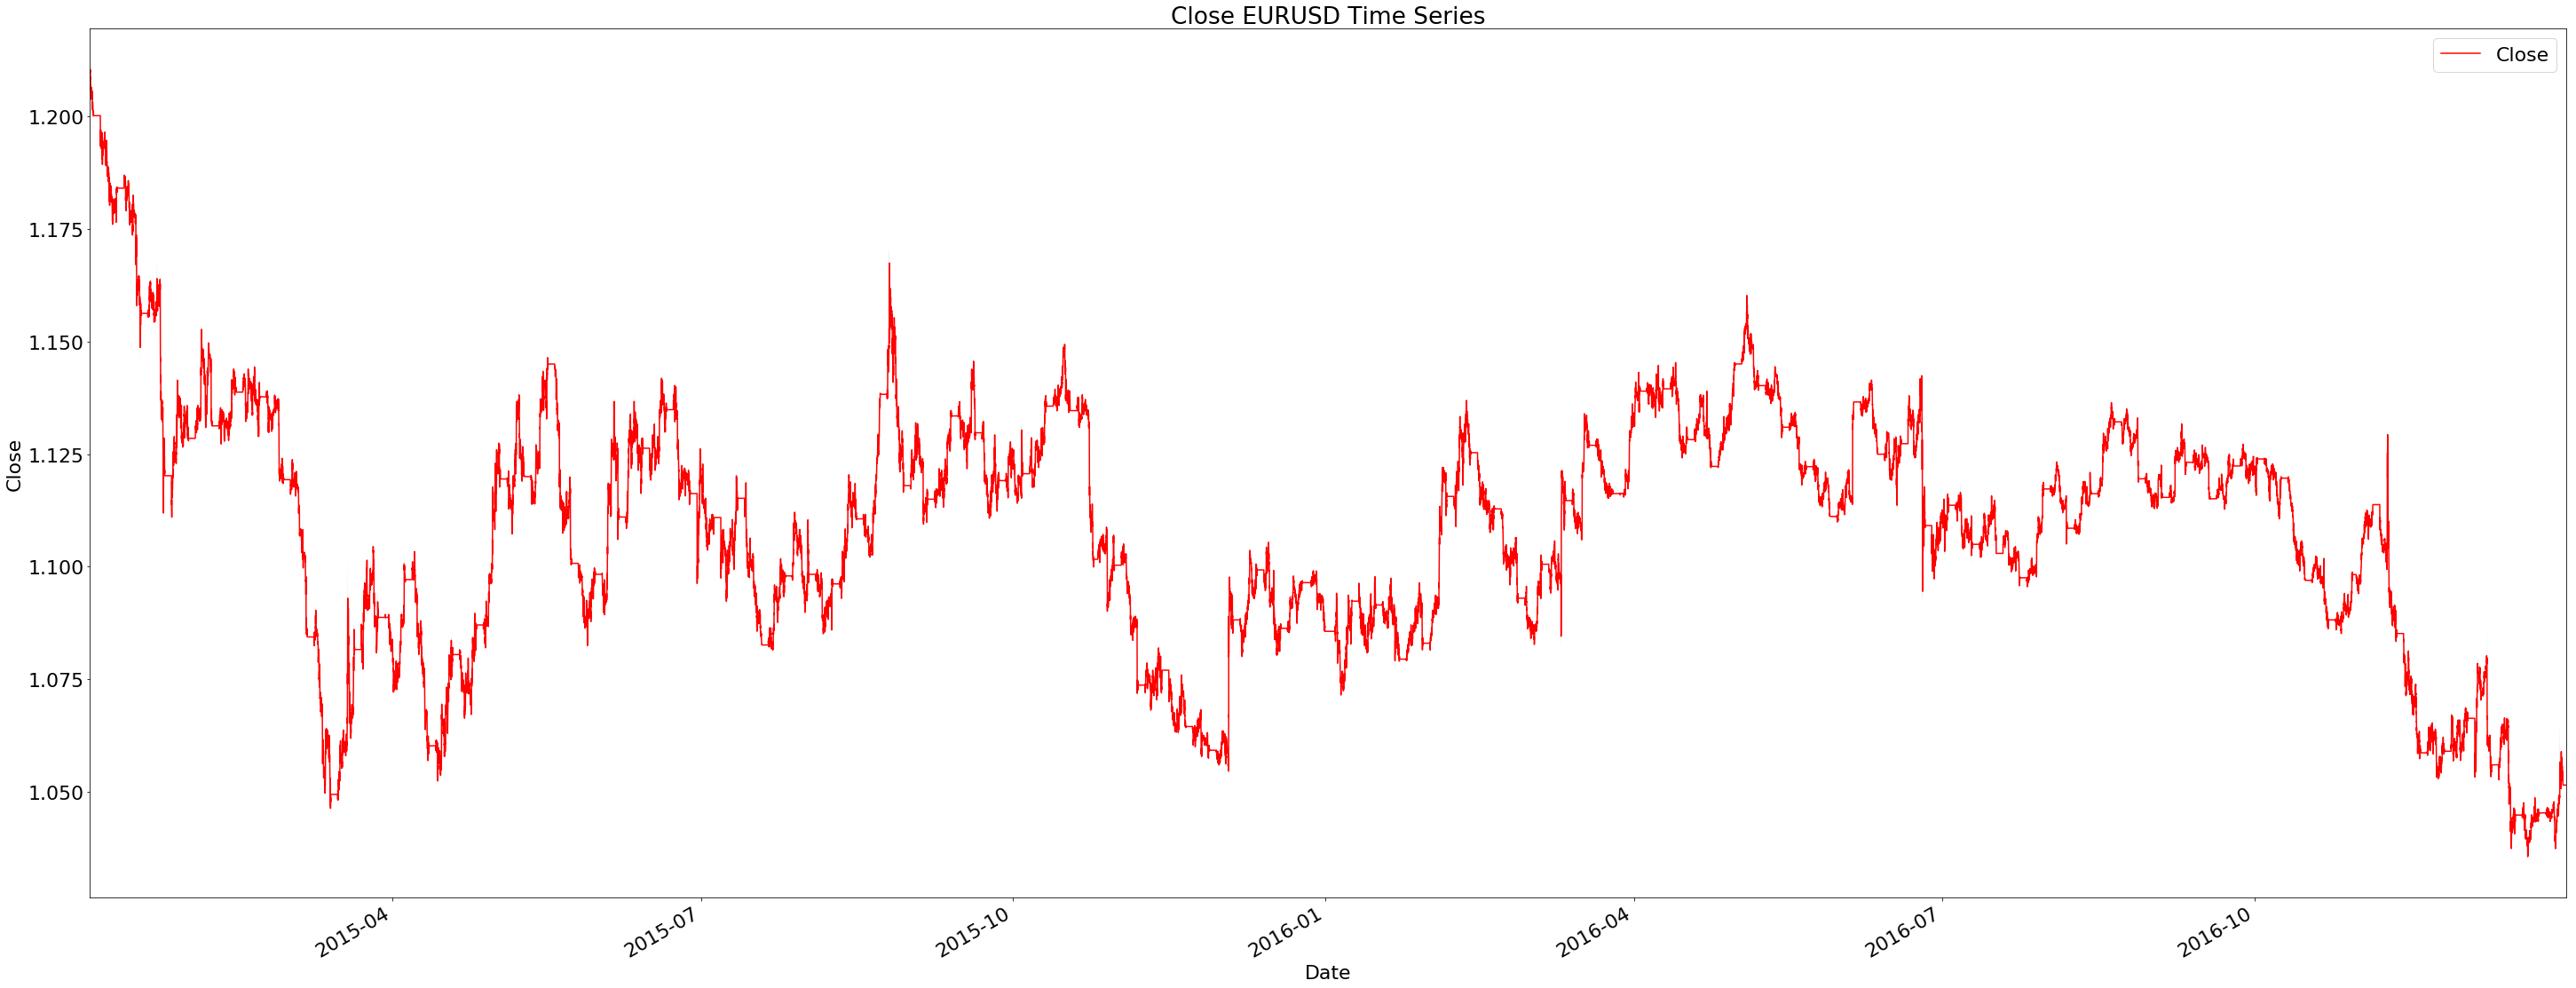

In [15]:
#look at the time series graph of the close price
plt.rcParams.update({'font.size': 22})
ax = data.plot( y='Close', c='red', figsize=(50,20))
i = [str(item) for item in data.index]
plt.fill_between(x=i, y1='Low',y2='High', data=data)
plt.ylabel("Close")
plt.title("Close EURUSD Time Series")
plt.show()

## Analysis: Random Forest for Finding the Most Importnat Features

In [16]:
#Define a function that defines the set of the past data (for the past 5 hours)
def make_5h_data(df, lag=20):
    X, Y = [], []
    for i in range(len(df)-lag-1):
        a = df[i:(i+lag)]
        X.append(a)
        Y.append(df[i + lag])
    return np.array(X), np.array(Y)

In [17]:
#Firstly, we scale the data we have using MinMaxScaler function to set values of all features to be between 0 and 1
close_ind = data.columns.tolist().index('Close')
dataframe = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataframe = scaler.fit_transform(dataframe)

#Now we create our variables x (independant) and y (dependent)
x, y = make_5h_data(dataframe, lag=1)
y = y[:,close_ind]
x = np.reshape(x, (x.shape[0], x.shape[2]))

In [18]:
x.shape

(70082, 17)

In [19]:
#now we fit random forest to find whart features are important in predicting close price in the next fifteen minutes
rf = RandomForestRegressor(n_estimators = 100)
rf = rf.fit(x, y) #fit random forest on the training set

In [20]:
#Here we rank the fatures by their importance
feature_importance = rf.feature_importances_
std = np.std([rf.feature_importances_ for forest in rf.estimators_], axis=0)
i = np.argsort(feature_importance)[::-1]

feature_names = data.columns.tolist()
print("Feature ranking:")
for feature in range(x.shape[1]-1):
    print ("%d. %s %d (%f)" % (feature, feature_names[i[feature]], i[feature], feature_importance[i[feature]]))

Feature ranking:
0. Close 3 (0.817311)
1. Ohlc_price 11 (0.148618)
2. Avg_price 9 (0.020298)
3. High 1 (0.006840)
4. Low 2 (0.004813)
5. Ema 13 (0.001017)
6. Open 0 (0.000822)
7. Range 10 (0.000042)
8. Bull_power 15 (0.000038)
9. Bear_power 14 (0.000035)
10. Momentum 8 (0.000032)
11. Oc_diff 12 (0.000029)
12. Week 7 (0.000026)
13. pca 16 (0.000021)
14. Hour 5 (0.000021)
15. Volume 4 (0.000020)


## LTSM Model

In [21]:
#Create DataSet for the Neural Net

#We again scale all of our features no make them between 0 and 1
close_index = data.columns.tolist().index('Close')
high_index = data.columns.tolist().index('High')
low_index = data.columns.tolist().index('Low')
dataframe = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataframe = scaler.fit_transform(dataframe)
scaled_y = MinMaxScaler(feature_range=(0, 1))
yt = data['Close'].values.astype('float32')
yt = np.reshape(yt, (-1, 1))
scaled_y = scaled_y.fit(yt)

In [22]:
#Now we create our variables x (independant) and y (dependent)
#here we can see that we're looking at the past five hours of data since the lag of 20 of 15 min is equal to the 5 hours
x, y = make_5h_data(dataframe, lag=20)
y = y[:,close_index]
print(x.shape) #we can see now that x is three dimensional
print(y.shape)

(70063, 20, 17)
(70063,)


In [23]:
#Define training and testing sets
#Our dataset is quite large that is why we choose 0.9 as our cutoff for the testing-trainig set split
cutoff = int(len(x) * 0.90)
x_train = x[:cutoff]
y_train = y[:cutoff]
x_test = x[cutoff:]
y_test = y[cutoff:]

### LTSM

In [24]:
model = Sequential()
model.add(LSTM(20, input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

#look at the model summary to see the layers and all of the parameters
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 20)            3040      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 10)            1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [25]:
#Here we create a check point in the model, which will update the best weights based on the validation error
#validation will be defined in the network fit to be 0.1 (10% of training data will be used as a validation set)
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

In [26]:
#now we fit the model on our training data
callbacks_list = [checkpoint]
ltsm1 = model.fit(x_train, y_train, epochs=200, batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mean_squared_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


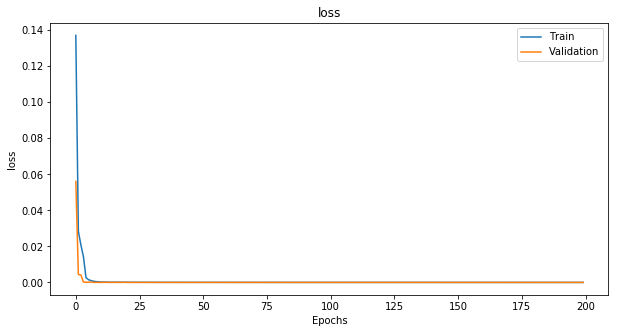

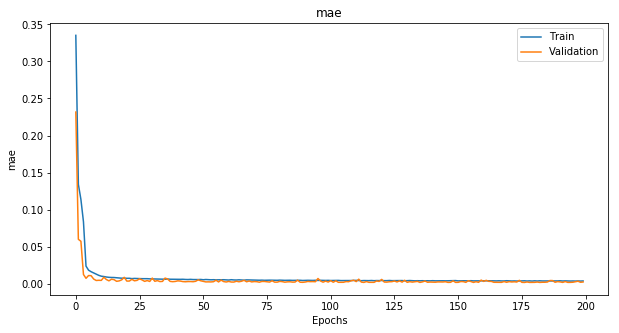

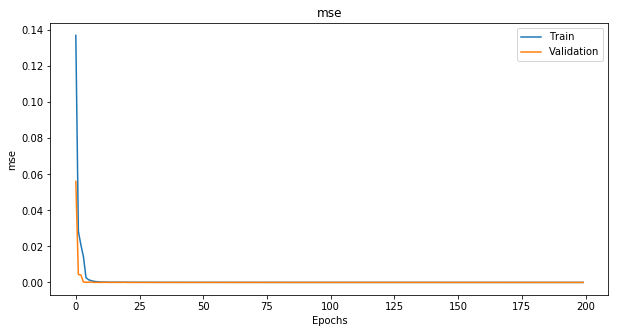

In [37]:
#create graphs to see how the validation error changes while the number of epochs increases

epoch = len(ltsm1.history['loss'])
for k in list(ltsm1.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(10,5))
        plt.plot(ltsm1.history[k])
        plt.plot(ltsm1.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

In [28]:
min(ltsm1.history['val_mae'])

0.0016088051488623023

In [29]:
min(ltsm1.history['val_mse'])

6.387833309418056e-06

## Look at the graphs of our prediction and see how it compares to the actual values

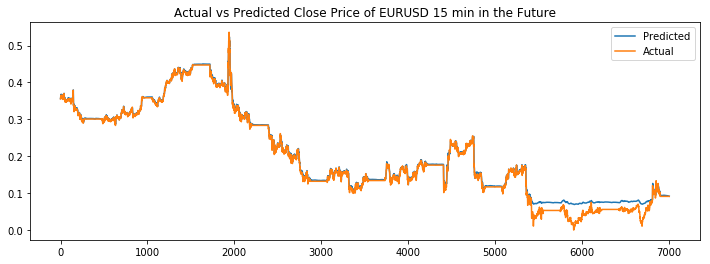

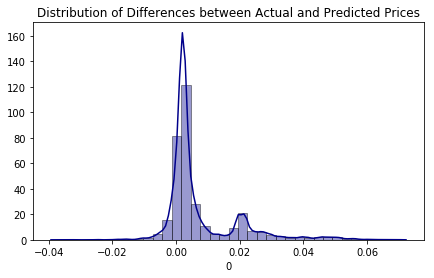

MSE :  0.00018331825
MAE :  0.0078689


,0
count,7007.000000
mean,0.007166
std,0.011489
min,-0.036906
25%,0.001322
50%,0.002607
75%,0.007207
max,0.069836


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Benchmark
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12,4))
plt.plot(model.predict(x_test))
plt.plot(y_test)
plt.title("Actual vs Predicted Close Price of EURUSD 15 min in the Future")
plt.legend(['Predicted', 'Actual'], loc='upper right')
plt.show()

diff = pd.DataFrame(model.predict(x_test))-pd.DataFrame(y_test)
plt.figure(figsize=(7,4))
sns.distplot(diff[0], hist=True,kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'})
plt.title('Distribution of Differences between Actual and Predicted Prices')
plt.show()

print("MSE : ", mean_squared_error(model.predict(x_test), y_test))
print("MAE : ", mean_absolute_error(model.predict(x_test), y_test))
diff.describe()

Notes:<br>
1) Why use PCA? “How do I take all of the variables I’ve collected and focus on only a few of them?” In technical terms, you want to “reduce the dimension of your feature space.” By reducing the dimension of your feature space, you have fewer relationships between variables to consider and you are less likely to overfit your model. <br>

Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! As an added benefit, each of the “new” variables after PCA are all independent of one another. <br>

https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c